In [1]:
use_extracted_data = False

In [2]:
import os
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from joblib import dump
from scipy.optimize import differential_evolution
from scipy.stats import (
    fit,
    gengamma,
)
from sklearn.neighbors import KernelDensity

from lib.check_files import check_prepared_data
from lib.erodep import clean_outliers


In [3]:
n_jobs = int(os.environ.get("N_JOBS", 8))
kde_bandwidth = int(os.environ.get("BANDWIDTH", 1000))
random_state = int(os.environ.get("RANDOM_STATE", 1234))
outlier_contamination = float(os.environ.get("CONTAMINATION", 0.06))
verbose = bool(int(os.environ.get("VERBOSE", 0)))

dist_name = "gengamma"
failure = "raise"  # or "ignore"

gengamma_bounds = {
    "a": (0, 50),
    "c": (-50, 50),
}


In [4]:
if use_extracted_data:
    data_dir = "extracted_data"
else:
    data_dir = "prepared_data"
    check_prepared_data(data_dir)
data_filename = os.path.join(data_dir, "training_data_global.csv")

outputs_dir = os.path.join("outputs", "global")
output_parametric = os.path.join(outputs_dir, "erodep_dist_parametric.joblib")
output_kde = os.path.join(outputs_dir, "erodep_dist_kde.joblib")
output_image = os.path.join(outputs_dir, "erodep_dists.png")


In [5]:
df = pd.read_csv(data_filename)
positives = df[df["label"] == "positive"]
unlabelled = df[df["label"] == "unlabelled"]

x_positives = np.array(positives["erosion (m)"])
x_unlabelled = np.array(unlabelled["erosion (m)"])


In [6]:
x_cleaned = clean_outliers(
    data=x_positives,
    contamination=outlier_contamination,
    n_jobs=n_jobs,
    random_state=random_state,
)
x_cleaned = x_cleaned[x_cleaned > 0.0]

In [7]:
def optimize_func(*args, **kwargs):
    return differential_evolution(*args, seed=random_state, **kwargs)


with warnings.catch_warnings():
    warnings.simplefilter("ignore", RuntimeWarning)
    fitted_params = fit(
        gengamma,
        data=x_cleaned,
        bounds=gengamma_bounds,
        optimizer=optimize_func,
    )
if not fitted_params.success:
    message = f"Optimisation failed! {fitted_params.message}"
    if failure == "raise":
        raise RuntimeError(message)
    else:
        warnings.warn(message, RuntimeWarning)

dist_parametric = gengamma(*(fitted_params.params))
nll_parametric = -1 * dist_parametric.logpdf(x_cleaned).sum()

dump(dist_parametric, output_parametric, compress=True)
if verbose:
    print(f"Parametric (gamma) distribution: NLL = {nll_parametric:0.0f}")
    print(
        f"""Writing parametric distribution to file: {output_parametric}"""
    )


Parametric (gamma) distribution: NLL = 4899
Writing parametric distribution to file: outputs/global/erodep_dist_parametric.joblib


In [8]:
kde = KernelDensity(
    kernel="gaussian",
    bandwidth=kde_bandwidth,
).fit(x_cleaned.reshape((-1, 1)))
nll_kde = -1 * kde.score(x_cleaned.reshape((-1, 1)))

dump(kde, output_kde, compress=True)
if verbose:
    print(
        f"Kernel density estimate (KDE; bandwidth = {kde_bandwidth}): NLL = {nll_kde:0.0f}"
    )
    print(
        f"""Writing KDE distribution to file: {output_kde}"""
    )


Kernel density estimate (KDE; bandwidth = 1000): NLL = 4923
Writing KDE distribution to file: outputs/global/erodep_dist_kde.joblib


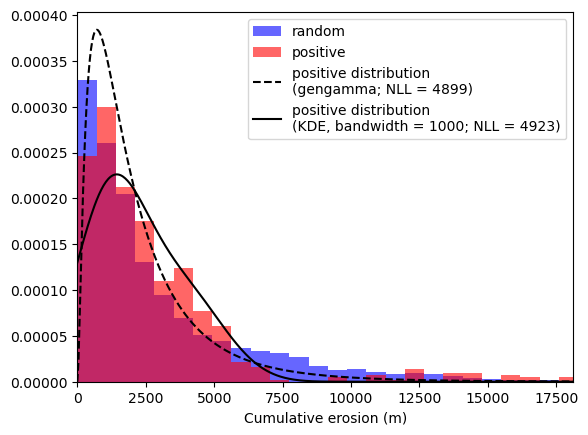

In [9]:
dist_x = np.linspace(
    positives["erosion (m)"].min(),
    positives["erosion (m)"].max(),
    500,
)
y_parametric = dist_parametric.pdf(dist_x)
y_kde = np.exp(kde.score_samples(dist_x.reshape((-1, 1))))

fig, ax = plt.subplots()
nbins = 30
_, bins, _ = ax.hist(
    unlabelled["erosion (m)"],
    bins=nbins,
    density=True,
    facecolor="blue",
    alpha=0.6,
    label="random",
)
ax.hist(
    positives["erosion (m)"],
    bins=bins,
    density=True,
    facecolor="red",
    alpha=0.6,
    label="positive",
)
ax.plot(
    dist_x,
    y_parametric,
    linestyle="dashed",
    color="black",
    zorder=10,
    label=f"positive distribution\n({dist_name}; NLL = {nll_parametric:0.0f})",
)
ax.plot(
    dist_x,
    y_kde,
    linestyle="solid",
    color="black",
    zorder=10,
    label=f"positive distribution\n(KDE, bandwidth = {kde_bandwidth}; NLL = {nll_kde:0.0f})",
)

ax.set_xlabel("Cumulative erosion (m)")
ax.set_xlim(0, positives["erosion (m)"].quantile(0.99))
ax.legend(loc="best")
fig.savefig(output_image, dpi=400, bbox_inches="tight")
